In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [26]:
data =  spec1d.Spec1d('../RXJ1131_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]


Reading spectrum from ../RXJ1131_spec.fits
Expected file format: mwa
 Spectrum Start:  5020.78
 Spectrum End:     8219.18
 Dispersion (1st pixel):   0.80
 Dispersion (average):      0.80



### Checking whether the redshift calculated from the galaxy spectra is correct by drawing the position of the absoprtion lines with the calculated redshift.


Line        lambda_rest  lambda_obs
----------  -----------  -----------
CN bandhd     3883.00       5028.48
CaII K        3933.67       5094.10
CaII H        3968.47       5139.17
H-delta       4101.00       5310.80
G-band        4305.00       5574.97
H-gamma       4340.00       5620.30
Fe4383        4383.00       5675.98
Ca4455        4455.00       5769.22
Fe4531        4531.00       5867.64
H-beta        4861.00       6294.99
Mg I (b)      5176.00       6702.92
Na I (D)      5889.95       7627.49
Na I (D)      5895.92       7635.22



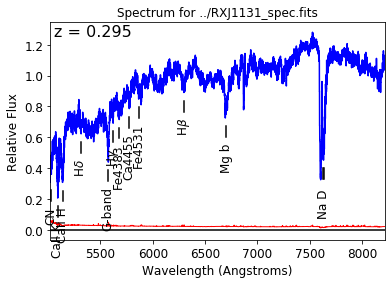

In [3]:
data.plot()
data.mark_lines('abs', z=0.295)

### Checking whether the wavelength range of the tamplate spectra from the Indo-US library covers the galaxy spectra given the redshift.

In [4]:
z = 0.295
lam_temp_ini = 3465.0       
lam_temp_fin = 9469.00
lam_range_min = lam_temp_ini*(1+z)
lam_range_max = lam_temp_fin*(1+z)
print(lam_range_min)
print(lam_range_max)

4487.175
12262.355


### Now we will start to calculate parameters to do the fit.

Velocity scale = 47.764433 km/s
dv = -111185.019848 


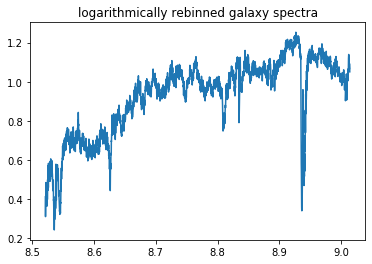

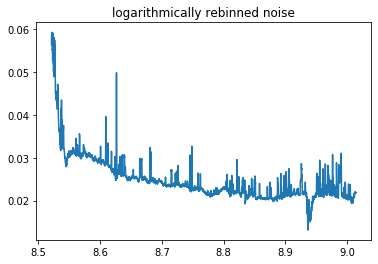

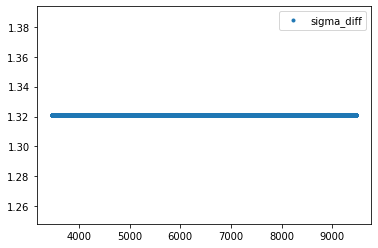

In [5]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(data['flux'])       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=1.44, lam_gal=lamda_galaxy)



In [ ]:
#%matplotlib notebook
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

In [15]:
mask_region = [[(8.8226, 8.8496), (8.9165, 9.0150)], [(8.5209, 8.5945), (8.8176, 8.8496), (8.9165, 9.0150)]]
 #              [(8.6173, 8.6320), (8.8226, 8.8496), (8.9171, 8.9611)],
 #              [(8.8217, 8.8496), (8.9165, 9.0150)],
 #              [(8.6173, 8.6320), (8.8217, 8.8496), (8.9165, 9.0150)],
 #              [(8.6173, 8.6320), (8.8216, 9.0150)],
 #              [(8.8216, 9.0150)],
 #              [(8.7956, 8.8218), (8.8226, 8.8496), (8.9171, 8.9611)],
 #              [(8.6173, 8.6320), (8.7956, 8.8218),(8.8226, 8.8496), (8.9171, 8.9611)],
 #              [(8.7956, 8.8218), (8.8216, 9.0150)],
              
# (8.8226, 8.8496), (8.9071, 8.9711)
# Ca region = (8.5209, 8.5545)
# Mg b region = (8.7956, 8.8218)
# G band region = (8.6173, 8.6320)
# sky contamination = (8.8226, 8.8496), (8.9171, 8.9611)

In [7]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff,
                                      v=velocity_scale)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77564       320    -0.010     0.037
chi2/DOF: 0.9369
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77556       329    -0.039     0.042
chi2/DOF: 0.9534
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 850


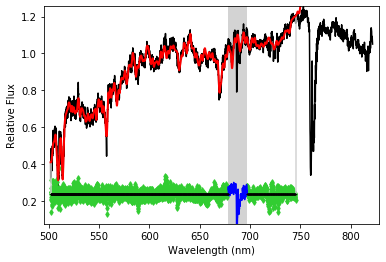

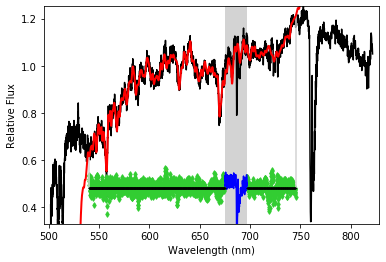

<Figure size 432x288 with 0 Axes>

In [19]:
for i, m in enumerate(mask_region):
    mask = vd.masking(m, log_lamda_galaxy)
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=7, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77556       322    -0.030     0.025
chi2/DOF: 1.059
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77554       329    -0.032     0.043
chi2/DOF: 0.9897
method = capfit; Jac calls: 5; Func calls: 27; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  16 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77554       330    -0.032     0.045
chi2/DOF: 0.9867
method = capfit; Jac calls: 5; Func calls: 27; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77556       329    -0.039     0.042
chi2/DOF: 0.9534
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 850
degree : 7
 Best Fit:       

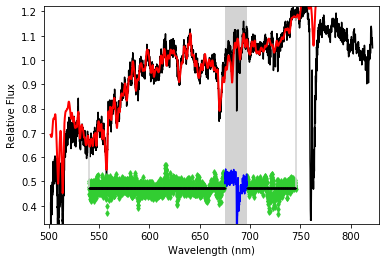

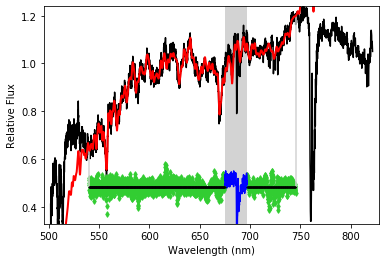

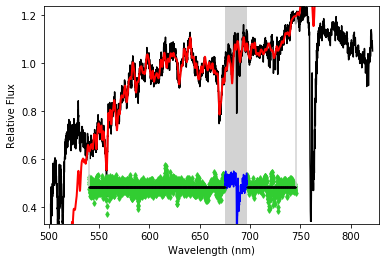

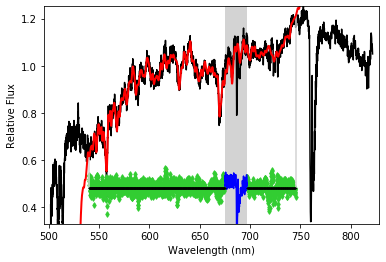

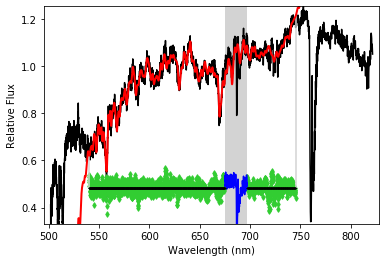

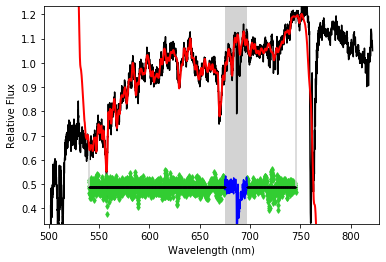

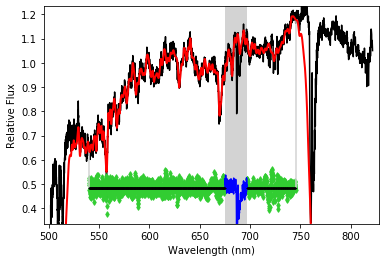

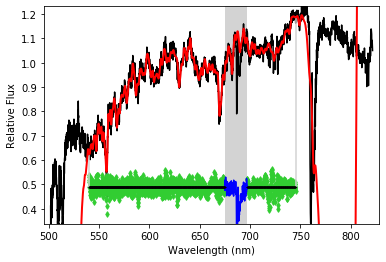

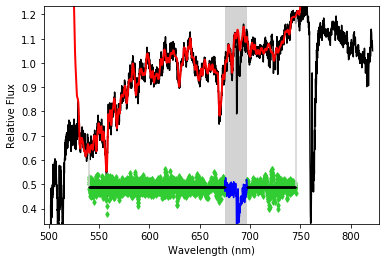

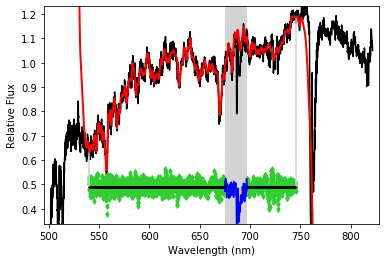

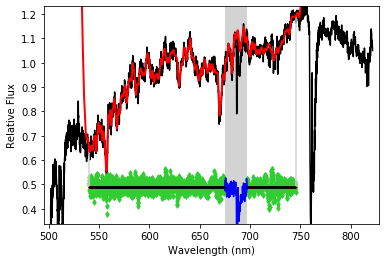

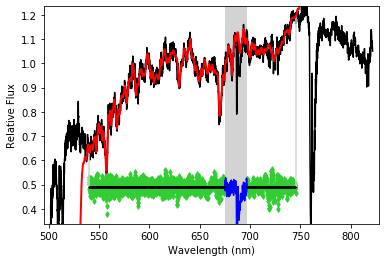

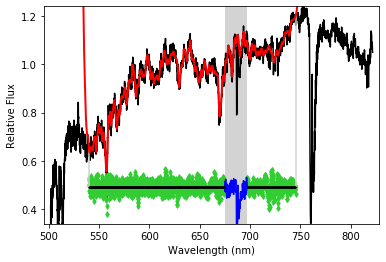

<Figure size 432x288 with 0 Axes>

In [22]:
degree = np.arange(4,17)
velocity_dispersion = np.zeros(len(degree))
mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    plt.figure()
    print('degree : %d' %degree[i])

In [42]:
lamda_galaxy = data['wav'][575:2800]
spectra_galaxy = data['flux'][575:2800]
variance_spectra_galaxy = data['var'][575:2800]
lamda_galaxy_range =  [lamda_galaxy[0], lamda_galaxy[-1]]

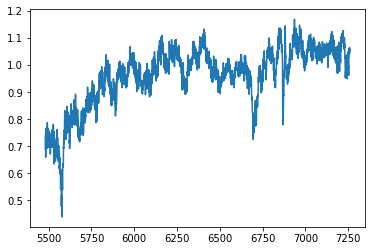

In [43]:
plt.plot(lamda_galaxy, spectra_galaxy)

Velocity scale = 43.755875 km/s
dv = -137465.448165 


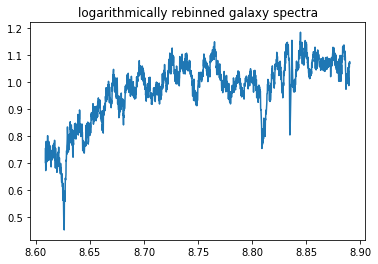

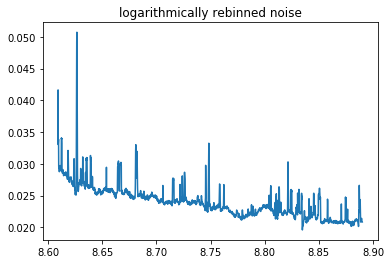

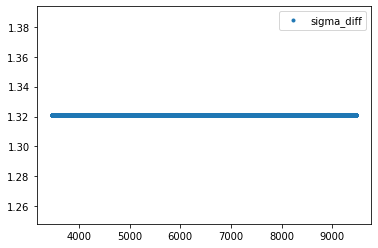

In [44]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=1.44, lam_gal=lamda_galaxy)



In [45]:
mask_region = [(8.8176, 8.8496)]

In [46]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff,
                                      v=velocity_scale)

In [47]:
print(velocity_scale)

43.755874952208785


 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77549       321    -0.037     0.029
chi2/DOF: 1.016
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77548       322    -0.037     0.031
chi2/DOF: 1.015
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77547       317    -0.035     0.025
chi2/DOF: 0.9955
method = capfit; Jac calls: 5; Func calls: 27; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77544       328    -0.045     0.043
chi2/DOF: 0.9708
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0: 

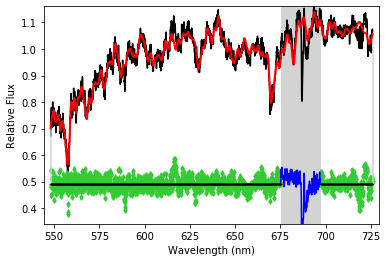

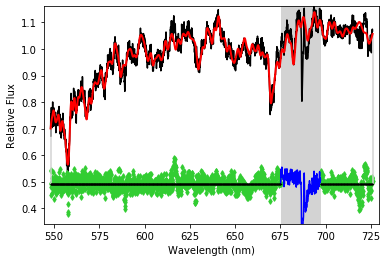

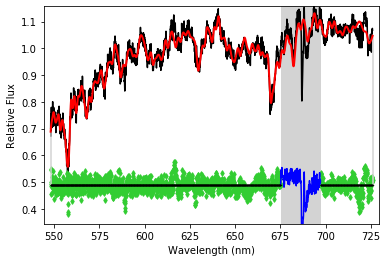

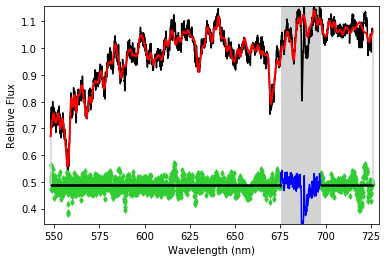

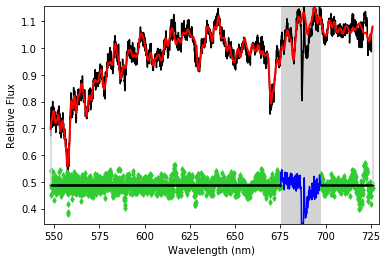

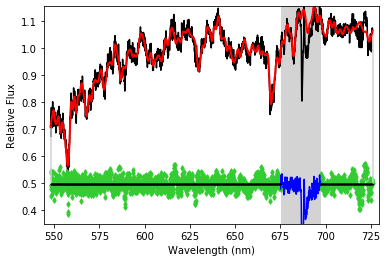

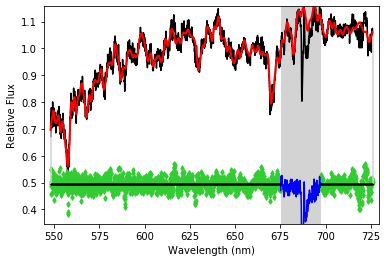

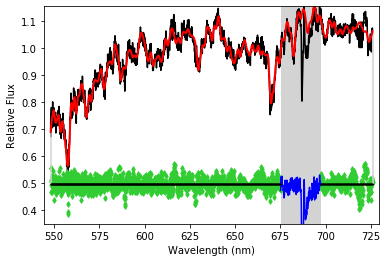

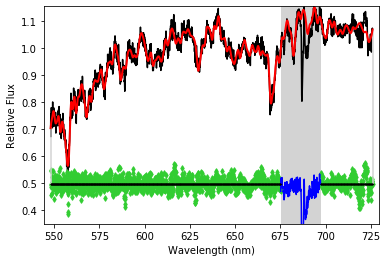

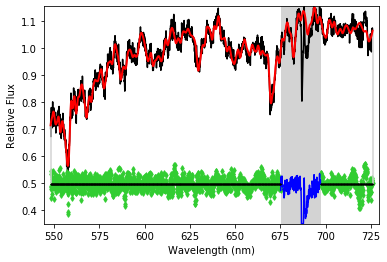

<Figure size 432x288 with 0 Axes>

In [49]:
mask = vd.masking(mask_region, log_lamda_galaxy)
degree = np.arange(4,14)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()

In [116]:
spectra_galaxy_1 = data['flux'][575:2125].tolist()
#lamda_galaxy = data['wav'][575:2800]
spectra_galaxy_2 = np.zeros(70)
lamda_galaxy_2 = np.zeros(70)
for i, p in enumerate(spectra_galaxy_2):
    lamda_galaxy_2[i] = data['wav'][2126+(i*5)]
    #print(data['wav'][2152+(i*5)])
    spectra_galaxy_2[i] = np.random.uniform(0.96, 1.07)
spectra_galaxy_2 = (np.interp(data['wav'][2125:2476], lamda_galaxy_2, spectra_galaxy_2)).tolist()
#spectra_galaxy_2 = np.random.uniform(0.95, 1.1, 325).tolist()

spectra_galaxy_3 = data['flux'][2476:2800].tolist()
spectra_galaxy = np.array(spectra_galaxy_1 + spectra_galaxy_2 + spectra_galaxy_3)


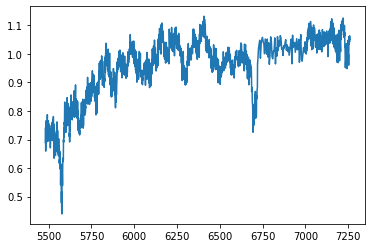

In [117]:
plt.plot(lamda_galaxy, np.array(spectra_galaxy))
#print(data['wav'][2130])

In [118]:
lamda_galaxy = data['wav'][575:2800]
variance_spectra_galaxy = data['var'][575:2800]
lamda_galaxy_range =  [lamda_galaxy[0], lamda_galaxy[-1]]

Velocity scale = 43.755875 km/s
dv = -137465.448165 


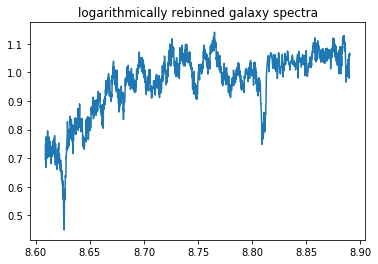

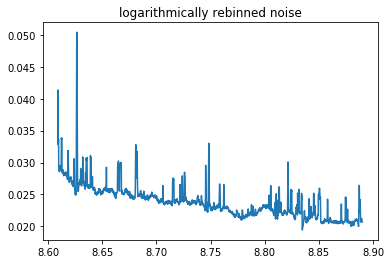

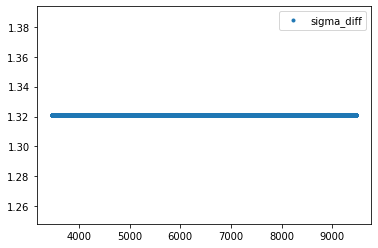

In [119]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=1.44, lam_gal=lamda_galaxy)



 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77537       320    -0.055     0.010
chi2/DOF: 1.366
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77533       321    -0.061     0.011
chi2/DOF: 1.361
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  19 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77534       322    -0.058     0.012
chi2/DOF: 1.358
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  16 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     77530       338    -0.062     0.044
chi2/DOF: 1.286
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:   

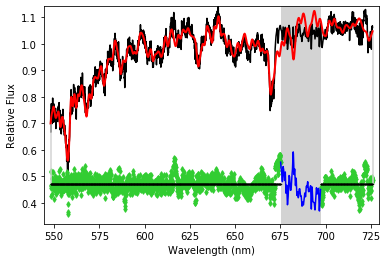

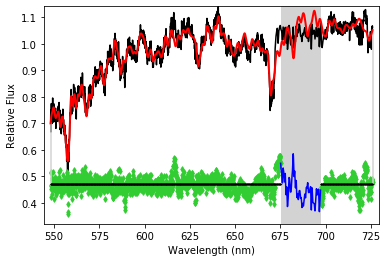

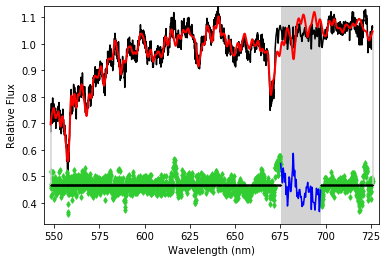

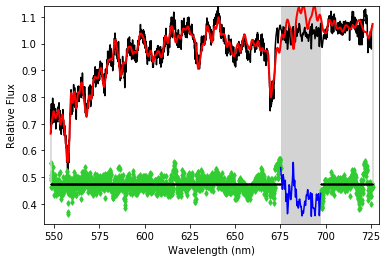

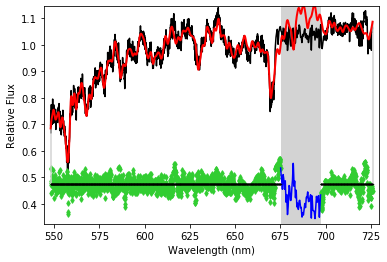

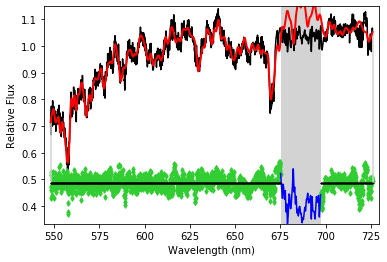

<Figure size 432x288 with 0 Axes>

In [123]:
degree = np.arange(4, 10)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()
    velocity_dispersion[i] = pp.sol[1]

<Figure size 432x288 with 0 Axes>

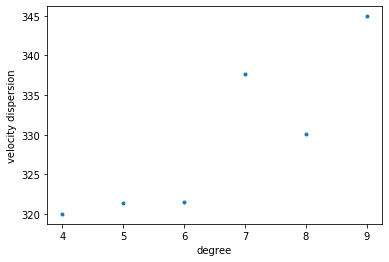

<Figure size 432x288 with 0 Axes>

In [124]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()